# Gaussian Mixture Model (GMM) region of interest (ROI) exploratory study
This notebook carries out the preliminary study on attenuation densities in a region of interest (ROI). It compares a ROI in patient 000 and 002, that has GGO, with the same ROI in patient 018 without GGO. The study tries to fit a GMM to the attenuation densities in the ROIs to compare areas with and without GGO.


In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

In [2]:
# Import function from other directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(os.path.join(parent_dir, "DataPreprocess"))
from main_preprocess import load_nifti_convert_to_numpy

/Users/bruger/anaconda3/envs/bachelor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'

data_paths = {
    "roi_ct": {
        "000": f"{data_path}/roi_ct_results/roi_result_000.nii.gz",
        "002": f"{data_path}/roi_ct_results/roi_result_002.nii.gz",
        "018_0": f"{data_path}/roi_ct_results/roi_result_018_0.nii.gz",
        "018_2": f"{data_path}/roi_ct_results/roi_result_018_2.nii.gz"
    }
}

ct_roi_results = {
    key: load_nifti_convert_to_numpy(input_path=path)
    for key, path in data_paths["roi_ct"].items()
}

In [4]:
# Flatten CT-ROI results, filter out zeros, and store in a dictionary
seg_result_arrays = {
    key: (
        result.flatten()[(result.flatten() != 0) & (result.flatten() > -2000)] 
        if not isinstance(result, list) 
        else [
            r.flatten()[(r.flatten() != 0) & (r.flatten() > -2000)] 
            for r in result
        ]
    )
    for key, result in ct_roi_results.items()
}

# Transforming the data

In [5]:
def transform_data(data, lamb=0.5, e=1e-6):
    translated_data = data + 1050 + e #make all values positive
    log_transformed = np.log(translated_data)
    sqrt_transformed = np.sqrt(translated_data)
    boxcox_transformed = (translated_data**lamb - 1)/lamb

    _, axes = plt.subplots(2, 2, figsize=(5, 5)) 
    transformations = [
        ('Original Data', translated_data),
        ('Log Transformed', log_transformed),
        ('Square Root Transformed', sqrt_transformed),
        (f'Box-Cox Transformed, lambda={lamb}', boxcox_transformed)
    ]

    for i, (title, transformed_data) in enumerate(transformations):
        ax = axes[i // 2, i % 2] 
        ax.hist(transformed_data, bins=50, color=np.random.rand(3,), alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

    return transformations

# GMM (gaussian mixture model)

In [ ]:
def plot_gmm(data):
    gmm = GaussianMixture(n_components=2) 
    gmm.fit(data.reshape(-1, 1))

    x = np.linspace(-1000, 200, 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x) 
    pdf = np.exp(logprob) 

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data histogram')
    plt.plot(x, pdf, label='Fitted GMM', color='red', lw=2)
    plt.title("Gaussian Mixture Model Fit to Data")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [8]:
def compute_aic_and_bic(log_likelihood, n, n_params):
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    
    return aic, bic

In [ ]:
def compare_gaussian_models(data, ax, transform=None, lamb=0.5):
    """
    Compares a single Gaussian model with a Gaussian Mixture Model (GMM)
    using AIC and BIC criteria and plots the results on the given axis.
    
    Parameters:
        data (array-like): 1D array-like data to fit the models.
        ax (matplotlib.axis): Axis to plot the results on.
        transform (str): Optional transformation to apply ('log', 'sqrt', 'boxcox').
        lamb (float): Lambda value for Box-Cox transformation (default is 0.5).
        
    Returns:
        None
    """
    if transform is not None:
        # # Translate data to make it strictly positive
        # data_translated = data - np.min(data) + 1e-6
        
        if transform == 'log':
            data = np.log(data_translated)
        elif transform == 'sqrt':
            data = np.sqrt(data_translated)
        elif transform == 'boxcox':
            data = (data_translated**lamb - 1) / lamb


    # Single Gaussian Model
    mean, std = np.mean(data), np.std(data)
    single_gaussian_pdf = stats.norm.pdf(np.sort(data), loc=mean, scale=std)

    # Fit GMM models with 2 and 3 components
    gmm2 = GaussianMixture(n_components=2, random_state=42)
    gmm2.fit(data.reshape(-1, 1))

    gmm3 = GaussianMixture(n_components=3, random_state=42)
    gmm3.fit(data.reshape(-1, 1))

    # Calculate AIC and BIC for the models
    n = len(data)
    
    log_likelihood_single = np.sum(np.log(single_gaussian_pdf))
    log_likelihood_gmm2 = gmm2.score(data.reshape(-1, 1)) * n
    log_likelihood_gmm3 = gmm3.score(data.reshape(-1, 1)) * n

    aic_single, bic_single = compute_aic_and_bic(log_likelihood_single, n, 2)
    aic_gmm2, bic_gmm2 = compute_aic_and_bic(log_likelihood_gmm2, n, 2 * 2)
    aic_gmm3, bic_gmm3 = compute_aic_and_bic(log_likelihood_gmm3, n, 2 * 3)

    best_aic = min(aic_single, aic_gmm2, aic_gmm3)
    best_bic = min(bic_single, bic_gmm2, bic_gmm3)

    if best_aic == aic_single:
        print(f"Best model according to AIC: Single Gaussian")
    elif best_aic == aic_gmm2:
        print(f"Best model according to AIC: GMM (2 components)")
    else:
        print(f"Best model according to AIC: GMM (3 components)")

    if best_bic == bic_single:
        print(f"Best model according to BIC: Single Gaussian")
    elif best_bic == bic_gmm2:
        print(f"Best model according to BIC: GMM (2 components)")
    else:
        print(f"Best model according to BIC: GMM (3 components)")

    print('\n')

    # Plot results on the provided axis
    x = np.linspace(np.min(data) - 2, np.max(data) + 2, 1000)
    ax.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Data histogram')
    ax.plot(np.sort(data), single_gaussian_pdf, label='Single Gaussian', color='yellow', lw=2)
    ax.plot(x, np.exp(gmm2.score_samples(x.reshape(-1, 1))), label='2 components', color='red', lw=2)
    ax.plot(x, np.exp(gmm3.score_samples(x.reshape(-1, 1))), label='3 components', color='blue', lw=2)
    ax.set_title("Comparison of Single Gaussian and GMM")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

In [10]:
# Sample
n_samples = 100000
sampled_data = {
    key: np.random.choice(arr, size=n_samples, replace=True)
    for key, arr in seg_result_arrays.items()
}

/Users/bruger/anaconda3/envs/bachelor/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best model according to AIC: GMM (2 components)
Best model according to BIC: GMM (2 components)


Best model according to AIC: GMM (2 components)
Best model according to BIC: GMM (2 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)




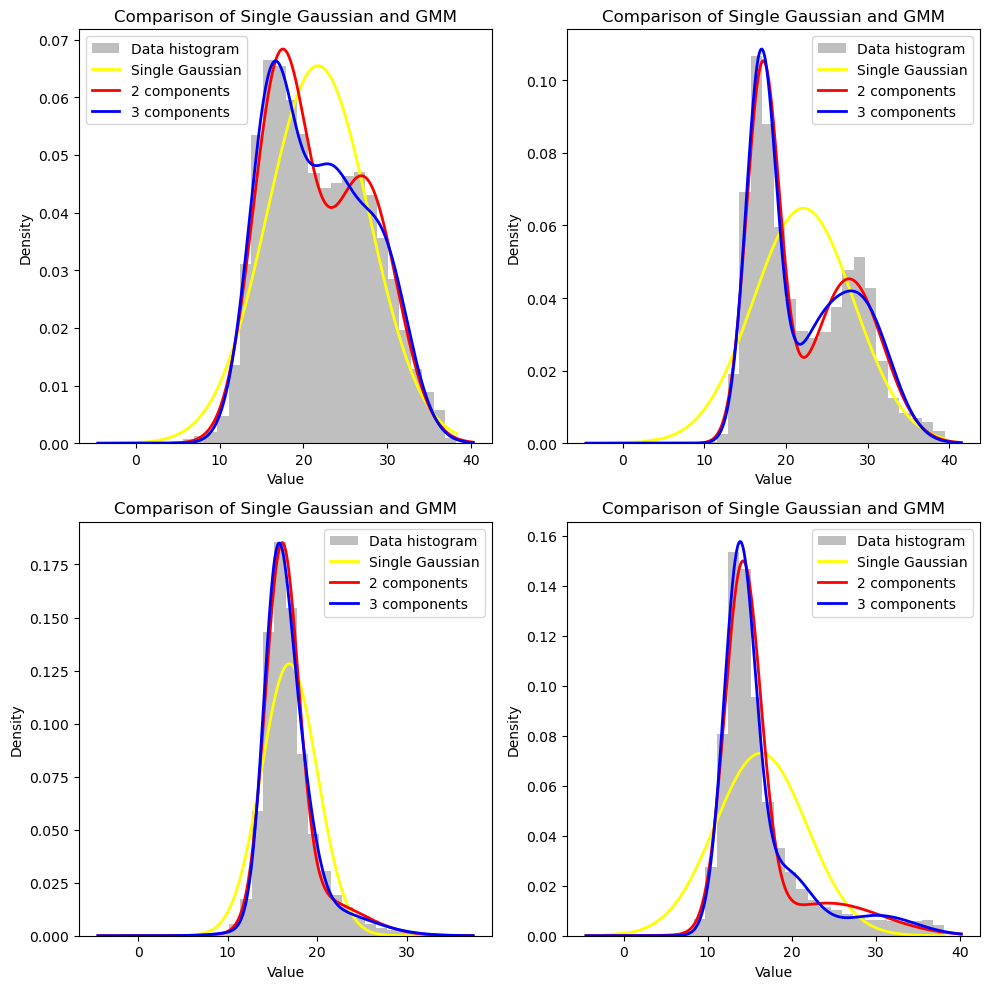

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, data in enumerate(sampled_data.values()):
    compare_gaussian_models(data, ax=axes[i], transform='boxcox', lamb=0.4)

plt.tight_layout()
plt.show()

## Filtering out low density data

In [12]:
def filter_low_density_data(data, density_threshold=0.0005):
    kde = stats.gaussian_kde(data)
    density = kde(data) 
    filtered_data = data[density >= density_threshold]
    return filtered_data

In [ ]:
filtered_data = {
    key: filter_low_density_data(seg_result_arrays[key])
    for key in seg_result_arrays
}

Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)


Best model according to AIC: GMM (3 components)
Best model according to BIC: GMM (3 components)




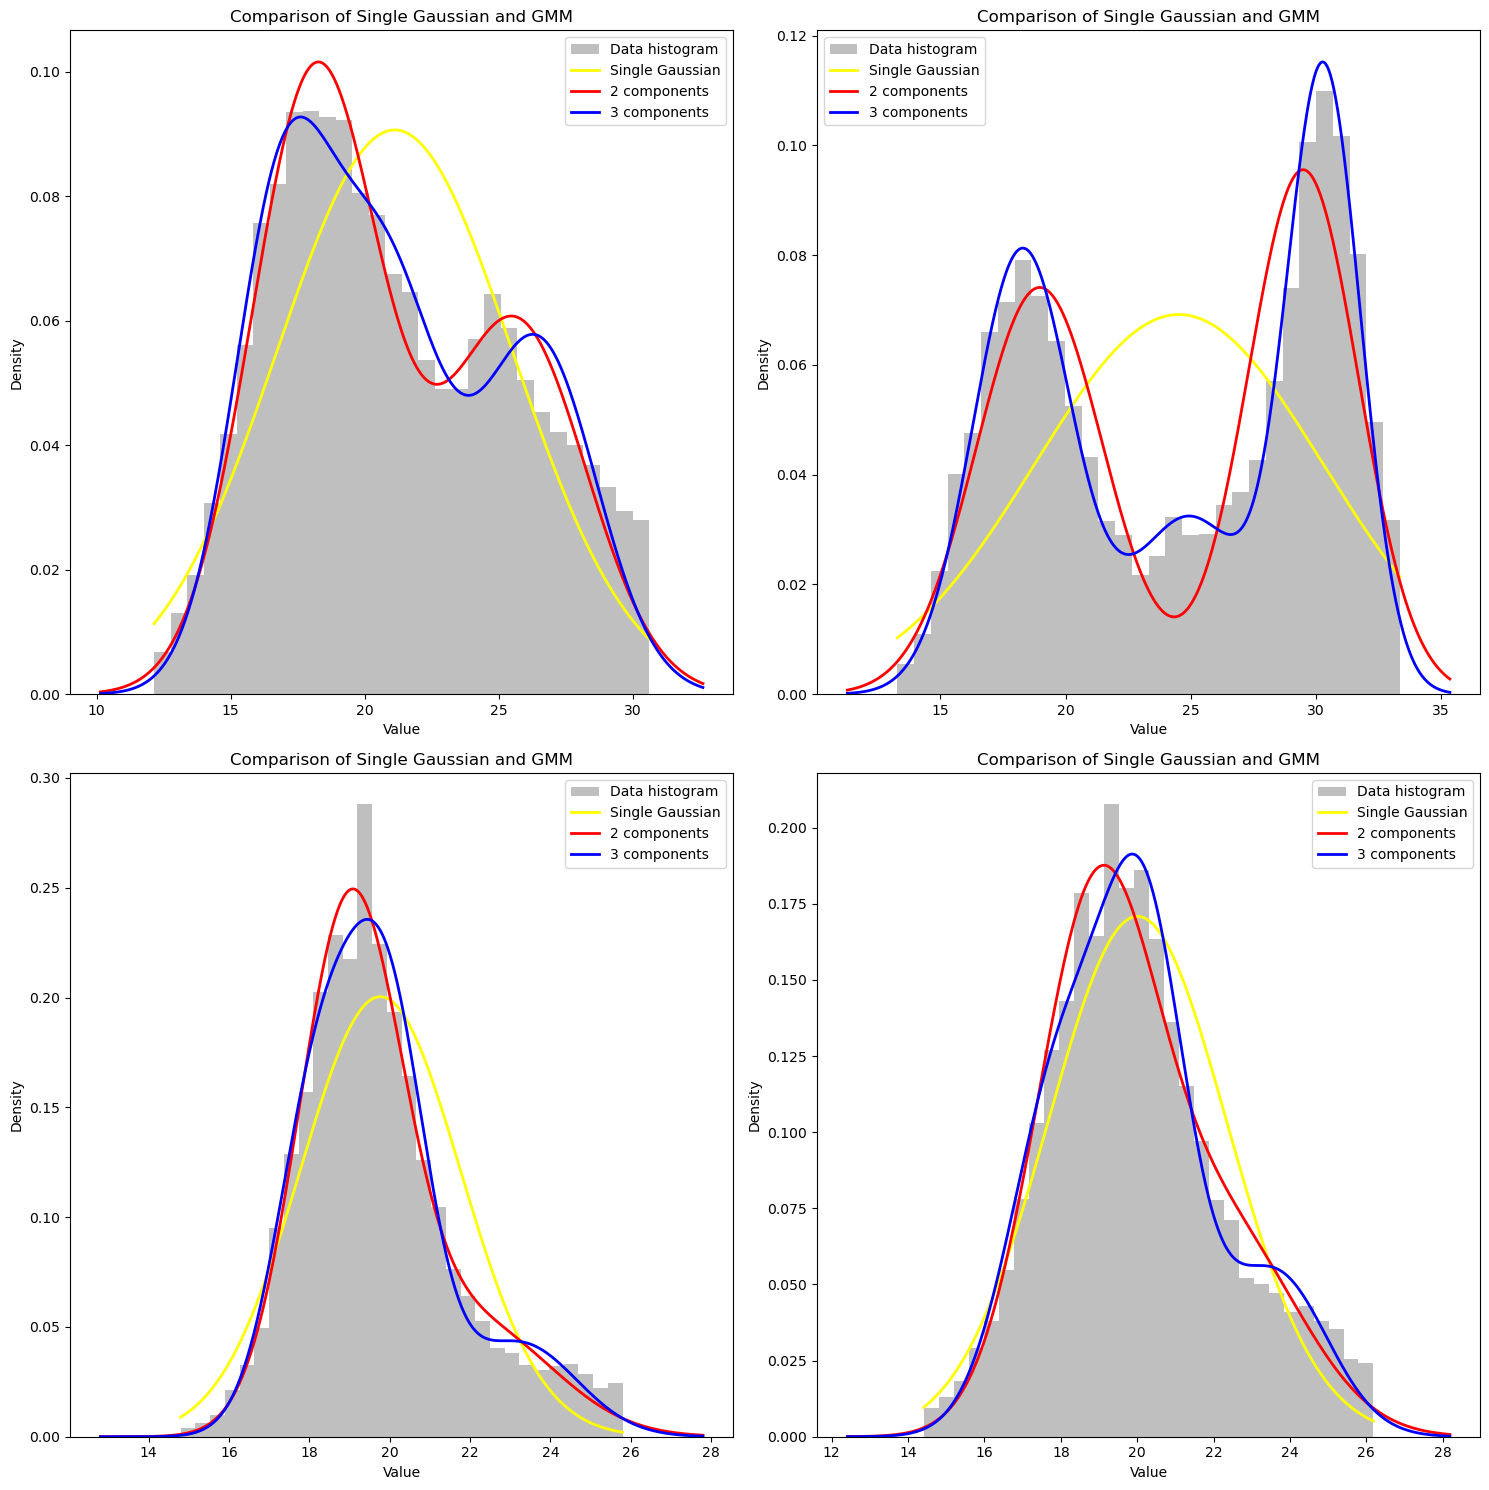

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, data in enumerate(filtered_data.values()):
    compare_gaussian_models(data, ax=axes[i], transform='boxcox', lamb=0.4)

plt.tight_layout()
plt.show()

## Run tests with transformed data

In [ ]:
# Define the pairs for statistical tests
pairs = [
    ("002", "018_0", seg_result_arrays["002"], seg_result_arrays["018_0"]),
    ("000", "018_2", seg_result_arrays["000"], seg_result_arrays["018_2"]),
    ("018_0", "018_2", seg_result_arrays["018_0"], seg_result_arrays["018_2"]),
]

# Perform Kruskal-Wallis and Kolmogorov-Smirnov tests for each pair
for label1, label2, data1, data2 in pairs:
    # Filter the data
    data1_filtered = filter_low_density_data(data1)
    data2_filtered = filter_low_density_data(data2)
    
    # Kruskal-Wallis Test
    _, pval_kw = stats.kruskal(data1_filtered, data2_filtered)
    print(f'Kruskal-Wallis test between {label1} and {label2} median: p-value = {pval_kw}')
    
    # Kolmogorov-Smirnov Test
    _, pval_ks = stats.ks_2samp(data1_filtered, data2_filtered)
    print(f'Kolmogorov-Smirnov test between {label1} and {label2} distribution: p-value = {pval_ks}')


In [ ]:
# # Kruskal-wallis: test if median is the same (non-parametric)

# _, pval_0002 = stats.kruskal(seg_result_0002_arr_filtered, seg_result_0018_arr_filtered)
# _, pval_0000 = stats.kruskal(seg_result_0000_arr_filtered, seg_result_0018_2_arr_filtered)
# _, pval_healthy = stats.kruskal(seg_result_0018_arr_filtered, seg_result_0018_2_arr_filtered)

# print(f'0002 and 0018 median are statistically significantly different with a p-value = {pval_0002}')
# print(f'0002 and 0018 median are statistically significantly different with a p-value = {round(pval_0000,5)}')
# print(f'0002 and 0018 median are statistically significantly different with a p-value = {round(pval_healthy,5)}')

0002 and 0018 median are statistically significantly different with a p-value = 0.0
0002 and 0018 median are statistically significantly different with a p-value = 0.0
0002 and 0018 median are statistically significantly different with a p-value = 0.0


In [ ]:
# # Kolmogorov-Smirnow: test if sample comes from reference distribution (non-parametric)

# _, pval_0002 = stats.ks_2samp(seg_result_0002_arr_filtered, seg_result_0018_arr_filtered)
# _, pval_0000 = stats.ks_2samp(seg_result_0000_arr_filtered, seg_result_0018_2_arr_filtered)
# _, pval_healthy = stats.ks_2samp(seg_result_0018_arr_filtered, seg_result_0018_2_arr_filtered)

# print(f'0002 and 0018 distribution are statistically significantly different with a p-value = {pval_0002}')
# print(f'0002 and 0018 distribution are statistically significantly different with a p-value = {round(pval_0000,5)}')
# print(f'0002 and 0018 distribution are statistically significantly different with a p-value = {round(pval_healthy,5)}')

0002 and 0018 distribution are statistically significantly different with a p-value = 0.0
0002 and 0018 distribution are statistically significantly different with a p-value = 0.0
0002 and 0018 distribution are statistically significantly different with a p-value = 0.0
